# Style Transfer

### Imports

In [7]:
import numpy as np
from PIL import Image
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from scipy.optimize import fmin_l_bfgs_b
import time

import os
import numpy as np
import librosa
import librosa.display
import pickle
import matplotlib.pyplot as plt

import cv2

%matplotlib inline

print(K.tensorflow_backend._get_available_gpus())

import tensorflow as tf

[]


In [2]:
dict_genres = {'Electronic': 1, 'Experimental': 2, 'Folk': 3, 'Hip-Hop': 4,
               'Instrumental': 5, 'International': 6, 'Pop': 7, 'Rock': 8}


def get_tids_from_directory(audio_dir):
    """Get track IDs from the mp3s in a directory.
    Parameters
    ----------
    audio_dir : str
        Path to the directory where the audio files are stored.
    Returns
    -------
        A list of track IDs.
    """
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids


def create_spectogram(audio_path):
    y, sr = librosa.load(audio_path)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T


def autocrop_image(location):
    im = cv2.imread(location, cv2.IMREAD_UNCHANGED)

    y, x = im[:, :, 3].nonzero()  # get the nonzero alpha coordinates
    minx = np.min(x)
    miny = np.min(y)
    maxx = np.max(x)
    maxy = np.max(y)

    cropImg = im[miny:maxy, minx:maxx]

    cv2.imwrite(location, cropImg)


def plot_spect(spect, title):
    print(spect.shape)
    fig = plt.figure(frameon=False, figsize=(10, 4))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.margins(0)
    plt.axis('off')
    plt.savefig(title, bbox_inches='tight', transparent=True, pad_inches=0)
    autocrop_image(title)


def create_array_and_save(audio_path, title, spectogram_title, pickle_out):
    genres = []
    X_spect = np.empty((0, 640, 128))
    spect = create_spectogram(audio_path)
    plot_spect(spect, spectogram_title)

    # Normalize for small shape differences
    spect = spect[:640, :]
    X_spect = np.append(X_spect, [spect], axis=0)

    if title == "content_audio":
        genres.append(dict_genres["Instrumental"])
    else:
        genres.append(dict_genres["Hip-Hop"])

    y_arr = np.array(genres)
    np.savez("dataset/" + title, X_spect, y_arr)

    pickle.dump(X_spect, pickle_out)


def preprocess_audio():
    content_audio_title = "content_audio"
    content_audio_spectogram = "dataset/content_spectogram.png"
    content_audio_path = "dataset/content_audio/Dee_Yan-Key_-_01_-_Elegy_for_Argus.mov"
    content_audio_spectogram_location = open("dataset/content_spectogram.pickle", "wb")
    content_audio = create_array_and_save(content_audio_path, content_audio_title, content_audio_spectogram,
                                          content_audio_spectogram_location)

    style_audio_title = "style_audio"
    style_audio_spectogram = "dataset/style_spectogram.png"
    style_audio_path = "dataset/style_audio/Yung_Kartz_-_02_-_Lethal.mov"
    style_audio_spectogram_location = open("dataset/style_spectogram.pickle", "wb")
    style_audio = create_array_and_save(style_audio_path, style_audio_title, style_audio_spectogram,
                                        style_audio_spectogram_location)

    return content_audio, style_audio

(852, 128)
(1057, 128)
Instructions for updating:
Colocations handled automatically by placer.


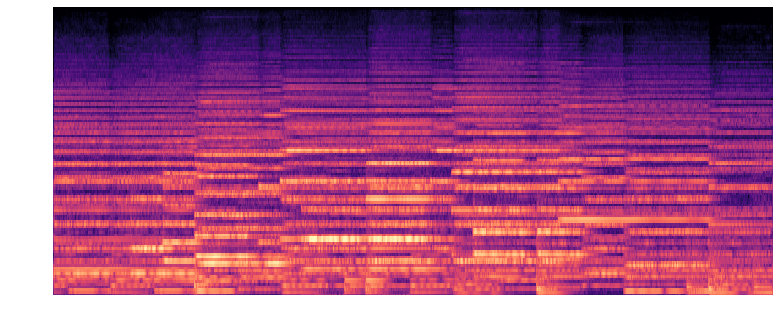

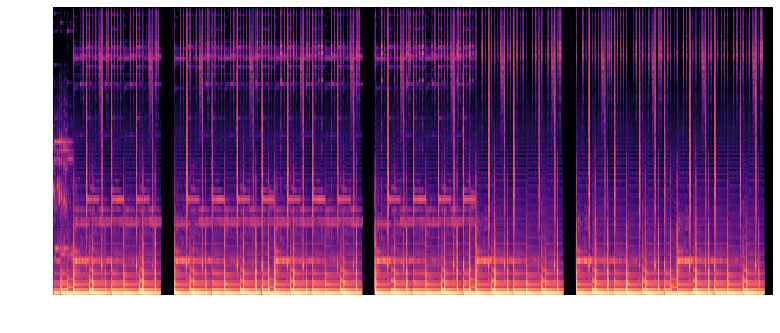

In [3]:
# Used lots of code from: https://github.com/walid0925/AI_Artistry/blob/master/main.py

# Preprocess audio into spectogram images
content_audio, style_audio = preprocess_audio()

content_image_path = './dataset/content_spectogram.png'
style_image_path = './dataset/style_spectogram.png'
generated_image_output_path = './dataset/output.png'

targetHeight = 128
targetWidth = 640
targetSize = (targetHeight, targetWidth)

cImageOrig = Image.open(content_image_path)
cImageSizeOrig = cImageOrig.size
cImage = load_img(path=content_image_path, target_size=targetSize)
cImArr = img_to_array(cImage)
cImArr = K.variable(preprocess_input(np.expand_dims(cImArr, axis=0)), dtype='float32')

sImage = load_img(path=style_image_path, target_size=targetSize)
sImArr = img_to_array(sImage)
sImArr = K.variable(preprocess_input(np.expand_dims(sImArr, axis=0)), dtype='float32')

gIm0 = np.random.randint(256, size=(targetWidth, targetHeight, 3)).astype('float64')
gIm0 = preprocess_input(np.expand_dims(gIm0, axis=0))

gImPlaceholder = K.placeholder(shape=(1, targetWidth, targetHeight, 3))

### Load Model

### Define Loss Functions

In [4]:
def get_feature_reps(x, layer_names, model):
    featMatrices = []
    for ln in layer_names:
        selectedLayer = model.get_layer(ln)
        featRaw = selectedLayer.output
        featRawShape = K.shape(featRaw).eval(session=tf_session)
        N_l = featRawShape[-1]
        M_l = featRawShape[1] * featRawShape[2]
        featMatrix = K.reshape(featRaw, (M_l, N_l))
        featMatrix = K.transpose(featMatrix)
        featMatrices.append(featMatrix)
    return featMatrices


def get_content_loss(F, P):
    cLoss = 0.5 * K.sum(K.square(F - P))
    return cLoss


def get_Gram_matrix(F):
    G = K.dot(F, K.transpose(F))
    return G


def get_style_loss(ws, Gs, As):
    sLoss = K.variable(0.)
    for w, G, A in zip(ws, Gs, As):
        M_l = K.int_shape(G)[1]
        N_l = K.int_shape(G)[0]
        G_gram = get_Gram_matrix(G)
        A_gram = get_Gram_matrix(A)
        sLoss += w * 0.25 * K.sum(K.square(G_gram - A_gram)) / (N_l ** 2 * M_l ** 2)
    return sLoss


def get_total_loss(gImPlaceholder, alpha=1.0, beta=10000.0):
    F = get_feature_reps(gImPlaceholder, layer_names=[cLayerName], model=gModel)[0]
    Gs = get_feature_reps(gImPlaceholder, layer_names=sLayerNames, model=gModel)
    contentLoss = get_content_loss(F, P)
    styleLoss = get_style_loss(ws, Gs, As)
    totalLoss = alpha * contentLoss + beta * styleLoss
    return totalLoss


def calculate_loss(gImArr):
    """
    Calculate total loss using K.function
    """
    if gImArr.shape != (1, targetWidth, targetWidth, 3):
        gImArr = gImArr.reshape((1, targetWidth, targetHeight, 3))
    loss_fcn = K.function([gModel.input], [get_total_loss(gModel.input)])
    return loss_fcn([gImArr])[0].astype('float64')


def get_grad(gImArr):
    """
    Calculate the gradient of the loss function with respect to the generated image
    """
    if gImArr.shape != (1, targetWidth, targetHeight, 3):
        gImArr = gImArr.reshape((1, targetWidth, targetHeight, 3))
    grad_fcn = K.function([gModel.input], K.gradients(get_total_loss(gModel.input), [gModel.input]))
    grad = grad_fcn([gImArr])[0].flatten().astype('float64')
    return grad

### Load Style and Content audios

In [5]:
def postprocess_array(x):
    # Zero-center by mean pixel
    if x.shape != (targetWidth, targetHeight, 3):
        x = x.reshape((targetWidth, targetHeight, 3))
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    # 'BGR'->'RGB'
    x = x[..., ::-1]
    x = np.clip(x, 0, 255)
    x = x.astype('uint8')
    return x


def reprocess_array(x):
    x = np.expand_dims(x.astype('float64'), axis=0)
    x = preprocess_input(x)
    return x


def save_original_size(x, target_size=cImageSizeOrig):
    xIm = Image.fromarray(x)
    xIm = xIm.resize(target_size)
    xIm.save(generated_image_output_path)
    return xIm


def deprocess_spectogram(path):
    pass

In [6]:
tf_session = K.get_session()
cModel = VGG16(include_top=False, weights='imagenet', input_tensor=cImArr)
sModel = VGG16(include_top=False, weights='imagenet', input_tensor=sImArr)
gModel = VGG16(include_top=False, weights='imagenet', input_tensor=gImPlaceholder)
cLayerName = 'block4_conv2'
sLayerNames = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    # 'block5_conv1'
]

P = get_feature_reps(x=cImArr, layer_names=[cLayerName], model=cModel)[0]
As = get_feature_reps(x=sImArr, layer_names=sLayerNames, model=sModel)
ws = np.ones(len(sLayerNames)) / float(len(sLayerNames))

iterations = 20
x_val = gIm0.flatten()
start = time.time()
xopt, f_val, info = fmin_l_bfgs_b(calculate_loss, x_val, fprime=get_grad,
                                  maxiter=iterations, disp=True)
xOut = postprocess_array(xopt)
xIm = save_original_size(xOut)
print('Image saved')
end = time.time()
print('Time taken: {}'.format(end - start))

deprocess_spectogram("dataset/output.png")


Image saved
Time taken: 137.3262357711792


# Run Style Transfer